In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import flows
from tqdm import tqdm_notebook as tqdm

In [2]:
# Unnormalized Density Function
def true_density(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

def true_density_np(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

In [3]:
pf = flows.PlanarFlow(dim=2, K=16)
device = torch.device('cpu')
pf = pf.to(device)
optimizer = torch.optim.Adam(pf.parameters(), lr=1e-2)

In [4]:
base = torch.distributions.normal.Normal(0., 1.)

In [5]:
pbar = tqdm(range(10000))
for i in pbar:
    optimizer.zero_grad()
    z0 = torch.randn(500, 2).to(device)
    zK, SLDJ = pf(z0, True)
    log_qk = base.log_prob(z0).sum(-1) + SLDJ.view(-1)
    log_p = torch.log(true_density(zK))
    kl = torch.mean(log_qk - log_p, 0)
    kl.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        pbar.set_description('KL: %.3f' % kl.item())

In [6]:
samples = []
for _ in tqdm(range(100)):
    z0 = torch.randn(500, 2)
    zK = pf(z0).detach().numpy()
    samples.append(zK)
samples = np.concatenate(samples)

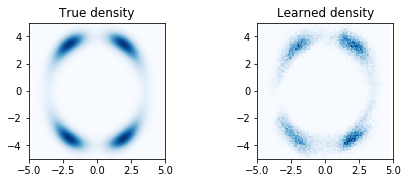

In [9]:
figure, axes = plt.subplots(1, 2, figsize=(7.5, 2.5))
# True Density
x = np.linspace(-5, 5, 500)
y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.flatten(), Y.flatten()]).T
density = true_density_np(data) # unnormalized
axes[0].pcolormesh(X, Y, density.reshape(X.shape), cmap='Blues')
# Learned Density
axes[1].hist2d(samples[:, 0], samples[:, 1], bins=100, cmap='Blues')
axes[0].set_title('True density')
axes[1].set_title('Learned density')
axes[0].axis('square')
axes[1].axis('square')
axes[0].set_xlim([-5, 5])
axes[0].set_ylim([-5, 5])
axes[1].set_xlim([-5, 5])
axes[1].set_ylim([-5, 5])
plt.savefig('assets/2ddensity.png', dpi=300)